In [1]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 311.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import logging
from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
file_path = "/content/drive/MyDrive/Thesis_Dataset/Fill_In_The_Gap.csv"

In [5]:
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='warn')

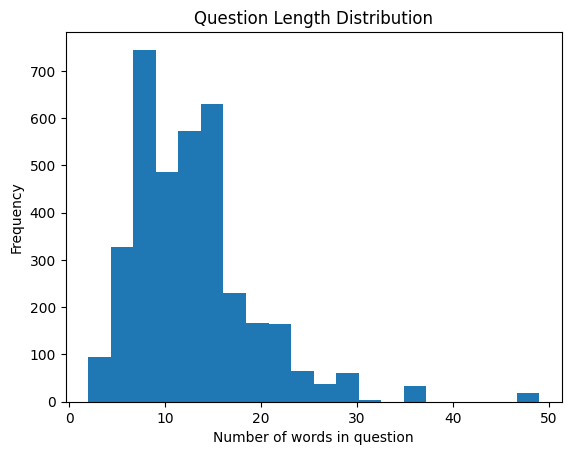

In [6]:
# Question length distribution
df['question_length'] = df['question'].apply(lambda x: len(x.split()))

plt.hist(df['question_length'], bins=20)
plt.title('Question Length Distribution')
plt.xlabel('Number of words in question')
plt.ylabel('Frequency')
plt.show()

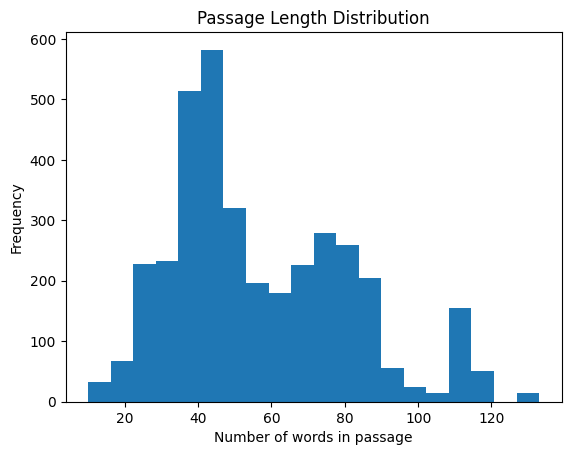

In [7]:
# Passage length distribution
df['passage_length'] = df['passage'].apply(lambda x: len(x.split()))

plt.hist(df['passage_length'], bins=20)
plt.title('Passage Length Distribution')
plt.xlabel('Number of words in passage')
plt.ylabel('Frequency')
plt.show()

In [8]:
qa_data = []
for index, row in df.iterrows():

    qa_entry = {
        "context": row['passage'],
        "qas": [
            {
                "id": f"unique_id_{index}",
                "is_impossible": False,
                "question": row['question'],
                "answers": [
                    {
                        "text": row['ans_txt'].strip(),
                        "answer_start": row['strt_ind']
                    }
                ]
            }
        ]
    }
    qa_data.append(qa_entry)

In [9]:
output_path = "/content/drive/MyDrive/Thesis_Dataset/Fill_In_The_Gap.json"

In [10]:
with open(output_path, 'w', encoding='utf-8') as json_file:
    json.dump(qa_data, json_file, ensure_ascii=False, indent=4)

In [11]:
with open(output_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

In [12]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
train_data_path = "/content/drive/MyDrive/Thesis_Dataset/train_fill_in_the_gap.json"
test_data_path = "/content/drive/MyDrive/Thesis_Dataset/test_fill_in_the_gap.json"

In [14]:
with open(train_data_path, 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

with open(test_data_path, 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

In [15]:
model_type="bert"
model_name= "bert-base-multilingual-cased"

In [16]:
model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True
model_args.num_train_epochs=20
model_args.learning_rate = 3e-5
model_args.max_seq_length = 512
model_args.n_best_size = 3

In [17]:
### Advanced Methodology
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "output_dir": f"outputs/{model_type}",
    "best_model_dir": f"outputs/{model_type}/best_model",
    "evaluate_during_training": True,
    "max_seq_length": 512,
    "num_train_epochs": 10,
    "evaluate_during_training_steps": 1000,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "n_best_size":3,
    "use_cuda": True,
    "train_batch_size": 16,
    "eval_batch_size": 8,
    # "use_early_stopping": True,
    # "early_stopping_metric": "mcc",
    # "n_gpu": 2,
    # "manual_seed": 4,
    # "use_multiprocessing": False,
    "train_batch_size": 16,
    "eval_batch_size": 64,
    # "config": {
    #     "output_hidden_states": True
    # }
}

In [18]:
import torch

In [19]:
torch.cuda.is_available()

True

In [20]:
model = QuestionAnsweringModel(
    model_type,model_name, args=train_args
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
model.train_model(train_data, eval_data=test_data)

add example index and unique id: 100%|██████████| 2908/2908 [00:00<00:00, 638989.73it/s]


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:697: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:720: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():

convert squad examples to features: 100%|██████████| 728/728 [00:02<00:00, 254.20it/s]

add example index and unique id: 100%|██████████| 728/728 [00:00<00:00, 607048.37it/s]


Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:1184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/182 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

(1820,
 {'global_step': [182, 364, 546, 728, 910, 1000, 1092, 1274, 1456, 1638, 1820],
  'correct': [630, 640, 641, 643, 645, 639, 651, 648, 651, 649, 652],
  'similar': [61, 62, 62, 56, 57, 62, 53, 53, 49, 49, 47],
  'incorrect': [37, 26, 25, 29, 26, 27, 24, 27, 28, 30, 29],
  'train_loss': [1.5092461109161377,
   0.0965358167886734,
   0.0013196567306295037,
   0.13261838257312775,
   0.020217418670654297,
   0.0006394945085048676,
   0.00036776065826416016,
   0.00022148588323034346,
   0.0638730525970459,
   0.0642634853720665,
   0.00041164952563121915],
  'eval_loss': [-5.729166666666667,
   -6.174479166666667,
   -7.572916666666667,
   -7.651041666666667,
   -7.906901041666667,
   -7.973958333333333,
   -8.061848958333334,
   -7.8955078125,
   -7.988606770833333,
   -8.030598958333334,
   -8.086588541666666]})

In [31]:
result, model_outputs = model.eval_model(
    test_data,
    acc=accuracy_score,
    f1=lambda truth, preds: f1_score(truth, preds, average='weighted'),
    precision=lambda truth, preds: precision_score(truth, preds, average='weighted'),
    recall=lambda truth, preds: recall_score(truth, preds, average='weighted'),
)

print(f"Accuracy: {result['acc']}")
print(f"F1-Score: {result['f1']}")
print(f"Precision: {result['precision']}")
print(f"Recall: {result['recall']}")

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch

Running Evaluation:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/question_answering/question_answering_model.py:1184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Accuracy: 0.8956043956043956
F1-Score: 0.8945673374244801
Precision: 0.9001831501831501
Recall: 0.8956043956043956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
to_predict = [
    {
        "context": "আমাদের দেশ এর নাম বাংলাদেশ। ঢাকা এদেশের রাজধানী। আনুমানিক ২ কোটি লোক এখানে বসবাস করে।",
        "qas": [
            {
                "question": "বাংলাদেশের রাজধানীর নাম [MASK]",
                "id": "0",
            }
        ],
    },
    {
        "context": "আমাদের দেশ এর নাম বাংলাদেশ। ঢাকা এদেশের রাজধানী। আনুমানিক ২ কোটি লোক এখানে বসবাস করে।",
        "qas": [
            {
                "question": "বাংলাদেশ এর রাজধানীতে আনুমানিক [MASK] লোক বসবাস করে।",
                "id": "1",
            }
        ],
    },
    {
        "context": "সিলেট বাংলাদেশ এর অন্যতম একটি বিভাগ। এটি মূলত চা এর জন্য বিখ্যাত। এছাড়াও সাস্ট এখানেই অবস্থিত।",
        "qas": [
            {
                "question": "সাস্ট [MASK] এ অবস্থিত।",
                "id": "2",
            }
        ],
    },
    {
        "context": "সিলেট বাংলাদেশ এর অন্যতম একটি বিভাগ। এটি মূলত চা এর জন্য বিখ্যাত। এছাড়াও সাস্ট এখানেই অবস্থিত।",
        "qas": [
            {
                "question": "সিলেট [MASK] এর জন্য বিখ্যাত।",
                "id": "3",
            }
        ],
    },

]

In [52]:
answers, probabilities = model.predict(to_predict)

add example index and unique id: 100%|██████████| 4/4 [00:00<00:00, 21648.02it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
for item in answers:
    print(f"ID: {item['id']}")
    print("Answers:")
    for answer in item['answer']:
        print(f"- {answer}")
    print("\n")

ID: 0
Answers:
- ঢাকা
- বাংলাদেশ। ঢাকা
- বাংলাদেশ


ID: 1
Answers:
- ২ কোটি
- ২
- টি


ID: 2
Answers:
- সিলেট
- সিলেট বাংলাদেশ এর অন্যতম একটি
- একটি


ID: 3
Answers:
- চা
- বাংলাদেশ এর অন্যতম একটি বিভাগ। এটি মূলত চা
- মূলত চা




In [54]:
for item in probabilities:
    print(f"ID: {item['id']}")
    print("Probabilities:")
    for prob in item['probability']:
        print(f"- {prob}")
    print("\n")

ID: 0
Probabilities:
- 0.9111328790213846
- 0.08524659058615189
- 0.0036205015840336265


ID: 1
Probabilities:
- 0.9999750577443731
- 2.2310030970833613e-05
- 2.632224655878909e-06


ID: 2
Probabilities:
- 0.45924755373707504
- 0.2848749565188393
- 0.25585949852628426


ID: 3
Probabilities:
- 0.7498933947454973
- 0.24440759577447616
- 0.005699009479498013


